In [ ]:
print("yay")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pymc as pm
import arviz as az
from scipy.stats import gaussian_kde, norm
import ipywidgets as widgets
from IPython.display import display, clear_output
import scipy.stats as st
from scipy.stats import gaussian_kde
from typing import Sequence, Tuple, Dict, Optional, Callable

print("Running with PyMC version:", pm.__version__)


C:\Users\castad001\AppData\Local\Temp\ipykernel_5152\2296320098.py:50: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=run_names, patch_artist=True, vert=True,
C:\Users\castad001\AppData\Local\Temp\ipykernel_5152\2296320098.py:50: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=run_names, patch_artist=True, vert=True,
C:\Users\castad001\AppData\Local\Temp\ipykernel_5152\2296320098.py:50: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, labels=run_names, patch_artist=True, vert=True,
C:\Users\castad001\AppData\Local\Temp\ipykernel_5152\2296320098.

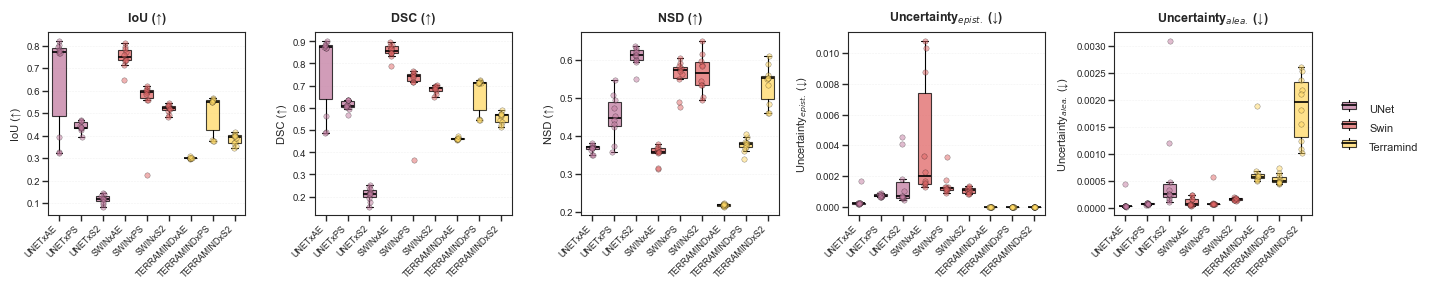

In [13]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch, Rectangle
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerBase

results_dir = r"N:\isipd\projects\p_planetdw\git\DriftwoodMappingBenchmark\analysis\result_safe"
csv_list = [os.path.join(results_dir, f) for f in os.listdir(results_dir) if f.endswith(".csv")]

combined_df = pd.concat((pd.read_csv(p) for p in csv_list), ignore_index=True)

# --- CONFIGURABLE COLOR MAP ---
MODEL_COLORS = {
    "UNet": "#c27ba0",
    "Swin": "#e06666",
    "Terramind":   "#ffd966",

}

def infer_model(run_name: str) -> str:
    s = str(run_name).lower()
    if "terramind" in s or "terraminf" in s:
        return "Terramind"
    if "unet" in s:
        return "UNet"
    if "swin" in s:
        return "Swin"


# Add model column for sorting
combined_df["model"] = combined_df["run_name"].apply(infer_model)

# --- MEANINGFUL ORDERING: by model type, then by run_name alphabetically ---
model_order = ["UNet", "Swin", "Terramind"]
run_names = sorted(
    combined_df["run_name"].dropna().unique(),
    key=lambda rn: (model_order.index(infer_model(rn)), rn)
)

def grouped_data(col):
    return [
        combined_df.loc[combined_df["run_name"] == rn, col].dropna().values
        for rn in run_names
    ]

def colored_boxplot(ax, col, title):
    data = grouped_data(col)
    bp = ax.boxplot(data, labels=run_names, patch_artist=True, vert=True,
                    showfliers=False, widths=0.6)  # narrower boxes

    # Explicit ticks so they render even if autoscale is tight
    ax.set_xticks(np.arange(1, len(run_names) + 1))

    # color each box by model
    for box, rn in zip(bp["boxes"], run_names):
        model = infer_model(rn)
        box.set_facecolor(MODEL_COLORS.get(model, "#dddddd"))
        box.set_edgecolor("black")
        box.set_linewidth(0.8)
        box.set_alpha(0.75)

    # style box plot elements - thinner for publication
    for line in bp["whiskers"]:
        line.set_color("black")
        line.set_linewidth(0.8)
    for line in bp["caps"]:
        line.set_color("black")
        line.set_linewidth(0.8)
    for line in bp["medians"]:
        line.set_color("black")
        line.set_linewidth(1.2)

    # --- ADD INDIVIDUAL DATA POINTS ---
    for i, (rn, values) in enumerate(zip(run_names, data)):
        if len(values) == 0:
            continue
        
        # Smaller jitter for cleaner appearance
        x_pos = np.random.normal(i + 1, 0.03, size=len(values))
        
        model = infer_model(rn)
        color = MODEL_COLORS.get(model, "#dddddd")
        
        ax.scatter(x_pos, values, alpha=0.5, s=15, 
                  color=color, edgecolors='black', linewidth=0.3, zorder=3)

    ax.set_title(title, fontsize=9, fontweight='bold', pad=8)
    ax.set_xlabel("")
    ax.set_ylabel(title, fontsize=8)
    # make the string dtart at the tick of the axis
    ax.tick_params(axis="x", labelsize=6.5, pad=2, bottom=True, top=False, labelbottom=True, 
                   direction="out", length=4, width=1.0)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.tick_params(axis="y", labelsize=7, pad=2, left=True, right=False, labelleft=True,
                   direction="out", length=4, width=1.0)
    ax.grid(axis='y', alpha=0.25, linestyle='--', linewidth=0.4)
    ax.set_axisbelow(True)
    
    # Tighten up the plot
    ax.margins(x=0.02)

# Custom legend handler for mini boxplots
class BoxplotHandler(HandlerBase):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        # Create a mini boxplot representation
        box_width = width * 0.6
        box_height = height * 0.5
        x_center = width / 2
        y_center = height / 2
        
        # Box (rectangle)
        box = Rectangle((x_center - box_width/2, y_center - box_height/2), 
                       box_width, box_height,
                       facecolor=orig_handle.get_facecolor(),
                       edgecolor='black',
                       linewidth=0.8,
                       alpha=0.75,
                       transform=trans)
        
        # Median line
        median = Line2D([x_center - box_width/2, x_center + box_width/2],
                       [y_center, y_center],
                       color='black', linewidth=1.2, transform=trans)
        
        # Whiskers
        whisker_top = Line2D([x_center, x_center],
                            [y_center + box_height/2, y_center + box_height/2 + height*0.15],
                            color='black', linewidth=0.8, transform=trans)
        whisker_bottom = Line2D([x_center, x_center],
                               [y_center - box_height/2, y_center - box_height/2 - height*0.15],
                               color='black', linewidth=0.8, transform=trans)
        
        return [box, median, whisker_top, whisker_bottom]

# --- SQUARE SUBPLOTS: 1x5 row format for RSE journal ---
# RSE prefers 174mm (6.85") width for 2-column figures
# For 1-column spanning figure, use ~84mm (3.3") height to maintain square-ish subplots
fig = plt.figure(figsize=(16, 2.5))

# Create subplots with minimal spacing - 1 row, 5 columns
gs = fig.add_gridspec(1, 5, hspace=0, wspace=0.35, 
                      left=0.06, right=0.85, top=0.88, bottom=0.15)

axs = []
for j in range(5):
    ax = fig.add_subplot(gs[0, j])
    axs.append(ax)

# Convert to numpy array for easier indexing
axs = np.array(axs)

colored_boxplot(axs[0], "IoU", "IoU (↑)")
colored_boxplot(axs[1], "dice_coef", "DSC (↑)")
colored_boxplot(axs[2], "normalized_surface_distance", "NSD (↑)")
colored_boxplot(axs[3], "mean_epistemic_uncertainty", "Uncertainty$_{epist.}$ (↓)")
colored_boxplot(axs[4], "mean_aleatoric_uncertainty", "Uncertainty$_{alea.}$ (↓)")

# Legend with mini boxplots on the right side
legend_handles = [
    Patch(facecolor=MODEL_COLORS[m], edgecolor="black", label=m, alpha=0.75, linewidth=0.8) 
    for m in model_order if m in MODEL_COLORS
]

fig.legend(handles=legend_handles, loc="center left", 
          bbox_to_anchor=(0.86, 0.5),
          frameon=False, fontsize=8,
          handler_map={Patch: BoxplotHandler()},
          handlelength=2.0, handleheight=1.5)

# Save as high-resolution figure for publication
# plt.savefig('model_comparison.pdf', dpi=300, bbox_inches='tight')
plt.savefig('./model_comparison.png', dpi=300, bbox_inches='tight')

plt.show()

found 400 training areas
data_split
training      29479
validation    10053
testing        8550
Name: count, dtype: int64


C:\Users\castad001\AppData\Local\Temp\ipykernel_5152\3407948492.py:423: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(cmap_name)
C:\Users\castad001\AppData\Local\Temp\ipykernel_5152\3407948492.py:184: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
C:\Users\castad001\AppData\Local\Temp\ipykernel_5152\3407948492.py:184: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
C:\Users\castad001\AppData\Local\Temp\ipykernel_5152\3407948492.py:184: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 't

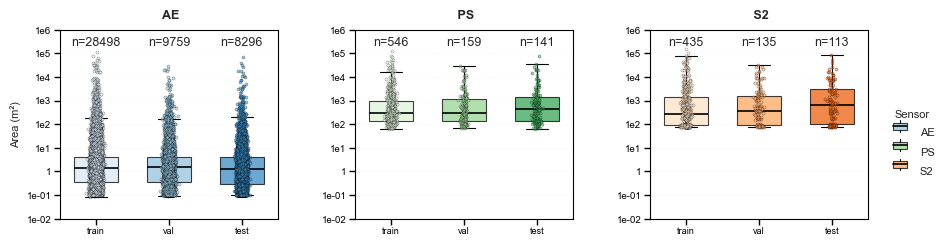

Saved plots: figs\area_boxplots_m2ticks.pdf and figs\area_boxplots_m2ticks.png
Saved: \\smb.isipd.dmawi.de\projects\p_planetdw\data\methods_test\training\AE\training_areas_with_split.gpkg


In [5]:
import json
from pathlib import Path
import re
from typing import Optional, List

import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.transforms import blended_transform_factory
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Patch, Rectangle
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerBase

import seaborn as sns  # kept for consistent base style (but we use matplotlib boxplots)


# ----------------------------
# USER OPTIONS (paper version)
# ----------------------------
# Toggle jittered sample points overlay
PLOT_POINTS = True

# Toggle sensor legend (mini boxplots)
PLOT_SENSOR_LEGEND = True

# Leave empty => draw an empty PS subplot (but keep the 3-panel layout)
LABELS_PS = ""

# (kept for compatibility; not used for boxplots)
BW_ADJUST = 1.0

TEXTOFF = 0.90

# Match your reference boxplot scatter overlay style
POINT_ALPHA = 0.5
POINT_SIZE = 5
POINT_EDGE_LW = 0.3
JITTER_SD = 0.03
RNG = np.random.default_rng(0)  # deterministic jitter


# ----------------------------
# PALETTE OPTIONS (CHOOSABLE CONSTANTS)
# ----------------------------
PANEL_ORDER = ["AE", "PS", "S2"]

MODALITY_CMAPS = {
    "AE": "Blues",
    "PS": "Greens",
    "S2": "Oranges",
}

PALETTE_SHADE_MIN = 0.15
PALETTE_SHADE_MAX = 0.65

SPLIT_ORDER = ["training", "validation", "testing"]


# ----------------------------
# Paths
# ----------------------------
TRAINING_AREAS = r"N:\isipd\projects\p_planetdw\data\methods_test\training\AE\training_areas.gpkg"

LABELS_S2 = r"N:\isipd\projects\p_planetdw\data\methods_test\training\S2\labels_S2_exp.gpkg"
LABELS_AE = r"N:\isipd\projects\p_planetdw\data\methods_test\training\AE\labels_AE.gpkg"
LABELS_PS = r"N:\isipd\projects\p_planetdw\data\methods_test\training\PS\labels_PS.gpkg"

DATA_SPLIT_AA = r"N:\isipd\projects\p_planetdw\data\methods_test\preprocessed\AE\aa_frames_list.json"

FIG_DIR = Path("figs")
FIG_DIR.mkdir(parents=True, exist_ok=True)
OUT_PDF = FIG_DIR / "area_boxplots_m2ticks.pdf"
OUT_PNG = FIG_DIR / "area_boxplots_m2ticks.png"

OUT_TRAINING_AREAS_SPLIT = (
    r"\\smb.isipd.dmawi.de\projects\p_planetdw\data\methods_test\training\AE\training_areas_with_split.gpkg"
)


# ----------------------------
# Helpers
# ----------------------------
def safe_read_labels(path: str, source: str) -> Optional[gpd.GeoDataFrame]:
    """Read a label file if path is non-empty. Return None if empty or read fails."""
    if path is None or str(path).strip() == "":
        return None
    try:
        gdf = gpd.read_file(path)
        if gdf is None or len(gdf) == 0:
            return None
        gdf = gdf.copy()
        gdf["source"] = source
        return gdf
    except Exception as e:
        print(f"[WARN] Could not read {source} labels from: {path}\n       {e}")
        return None


def make_valid(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """Best-effort geometry validity fix (works well with shapely>=2)."""
    gdf = gdf.copy()
    try:
        gdf["geometry"] = gdf.geometry.make_valid()
    except Exception:
        pass
    return gdf


def sci_compact(x: float) -> str:
    """Compact scientific formatting for tick labels: 1e+03 -> 1e3."""
    if not np.isfinite(x) or x <= 0:
        return ""
    s = f"{x:.0e}"  # e.g. 1e+03
    s = s.replace("e+0", "e").replace("e+", "e").replace("e0", "")
    if re.fullmatch(r"-?\d+e0", s):
        s = s.replace("e0", "")
    return s


def apply_axes_frame_like_reference(ax):
    """Match the 'boxed frame' look of your reference figure (and force ticks ON)."""
    for side in ["left", "right", "top", "bottom"]:
        ax.spines[side].set_visible(True)
        ax.spines[side].set_linewidth(0.8)
        ax.spines[side].set_color("black")

    # IMPORTANT: seaborn "white" style can disable ticks (bottom/left). Force them back on.
    ax.tick_params(
        axis="x", which="both",
        bottom=True, top=False, labelbottom=True,
        labelsize=6.5, pad=2, direction="out", length=4, width=1.0,
        colors="black"
    )
    ax.tick_params(
        axis="y", which="both",
        left=True, right=False, labelleft=True,
        labelsize=7, pad=2, direction="out", length=4, width=1.0,
        colors="black"
    )

    ax.grid(axis="y", alpha=0.18, linestyle="--", linewidth=0.4)
    ax.set_axisbelow(True)


def empty_panel(ax, title: str, ns: List[int], ylabel: Optional[str] = None):
    ax.set_title(title, fontsize=9, fontweight="bold", pad=8)  # centered like reference
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=8)

    ax.set_xticks([1, 2, 3])
    ax.set_xticklabels(["train", "val", "test"])
    ax.set_xlabel("")

    # n labels centered above each category
    trans = blended_transform_factory(ax.transData, ax.transAxes)
    for i, n in enumerate(ns, start=1):
        ax.text(
            i, TEXTOFF, f"n={n}",
            transform=trans, ha="center", va="bottom",
            fontsize=9, clip_on=False
        )

    apply_axes_frame_like_reference(ax)
    ax.set_xlim(0.5, 3.5)
    ax.text(
        0.5, 0.5, "No data", transform=ax.transAxes,
        ha="center", va="center", alpha=0.6
    )


def colored_boxplot_with_points(ax, data_by_split, split_order, split_palette, title, ylabel=None, ns=None):
    """
    Boxplots + optional jittered points, styled to match your reference boxplot figure
    (full frame, thin black lines, alpha boxes, faint dashed y-grid).
    """
    data = [data_by_split.get(sp, np.array([])) for sp in split_order]
    labels = ["train", "val", "test"]

    bp = ax.boxplot(
        data,
        labels=labels,
        patch_artist=True,
        vert=True,
        showfliers=False,
        widths=0.6
    )

    # color each box by split shade
    for box, sp in zip(bp["boxes"], split_order):
        box.set_facecolor(split_palette.get(sp, "#dddddd"))
        box.set_edgecolor("black")
        box.set_linewidth(0.8)
        box.set_alpha(0.75)

    # style elements (match reference)
    for line in bp["whiskers"]:
        line.set_color("black")
        line.set_linewidth(0.8)
    for line in bp["caps"]:
        line.set_color("black")
        line.set_linewidth(0.8)
    for line in bp["medians"]:
        line.set_color("black")
        line.set_linewidth(1.2)

    # jittered points (toggle)
    if PLOT_POINTS:
        for i, sp in enumerate(split_order, start=1):
            vals = data_by_split.get(sp, np.array([]))
            if vals is None or len(vals) == 0:
                continue
            x_pos = RNG.normal(loc=i, scale=JITTER_SD, size=len(vals))
            ax.scatter(
                x_pos, vals,
                alpha=POINT_ALPHA,
                s=POINT_SIZE,
                color=split_palette.get(sp, "#dddddd"),
                edgecolors="black",
                linewidth=POINT_EDGE_LW,
                zorder=3
            )

    ax.set_title(title, fontsize=9, fontweight="bold", pad=8)  # centered
    ax.set_xlabel("")
    ax.set_ylabel(ylabel if ylabel else "", fontsize=8)

    apply_axes_frame_like_reference(ax)
    ax.set_xlim(0.5, 3.5)
    ax.margins(x=0.02)

    # n labels above each category
    if ns is not None:
        trans = blended_transform_factory(ax.transData, ax.transAxes)
        for i, n in enumerate(ns, start=1):
            ax.text(
                i, TEXTOFF, f"n={n}",
                transform=trans, ha="center", va="bottom",
                fontsize=9, clip_on=False
            )


# --- Custom legend handler for mini boxplots (like your model-comparison figure) ---
class BoxplotHandler(HandlerBase):
    def create_artists(self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans):
        box_width = width * 0.65
        box_height = height * 0.50
        x_center = xdescent + width / 2
        y_center = ydescent + height / 2

        # box
        box = Rectangle(
            (x_center - box_width / 2, y_center - box_height / 2),
            box_width, box_height,
            facecolor=orig_handle.get_facecolor(),
            edgecolor="black",
            linewidth=0.8,
            alpha=0.75,
            transform=trans
        )

        # median
        median = Line2D(
            [x_center - box_width / 2, x_center + box_width / 2],
            [y_center, y_center],
            color="black",
            linewidth=1.2,
            transform=trans
        )

        # whiskers
        whisker_top = Line2D(
            [x_center, x_center],
            [y_center + box_height / 2, y_center + box_height / 2 + height * 0.18],
            color="black",
            linewidth=0.8,
            transform=trans
        )
        whisker_bottom = Line2D(
            [x_center, x_center],
            [y_center - box_height / 2, y_center - box_height / 2 - height * 0.18],
            color="black",
            linewidth=0.8,
            transform=trans
        )

        return [box, median, whisker_top, whisker_bottom]


# ----------------------------
# Load labels (PS optional)
# ----------------------------
labels_s2 = safe_read_labels(LABELS_S2, "S2")
labels_ae = safe_read_labels(LABELS_AE, "AE")
labels_ps = safe_read_labels(LABELS_PS, "PS")  # None if empty

loaded = [g for g in (labels_s2, labels_ae, labels_ps) if g is not None]
if not loaded:
    raise RuntimeError("No label files could be loaded (S2/AE/PS).")

# Harmonize CRS across loaded layers
base_crs = loaded[0].crs
for i in range(len(loaded)):
    if loaded[i].crs != base_crs:
        loaded[i] = loaded[i].to_crs(base_crs)

all_labels = gpd.GeoDataFrame(pd.concat(loaded, ignore_index=True), crs=base_crs)

# ----------------------------
# Load training areas and align CRS
# ----------------------------
training_areas = gpd.read_file(TRAINING_AREAS)
print(f"found {len(training_areas)} training areas")

if training_areas.crs != all_labels.crs:
    training_areas = training_areas.to_crs(all_labels.crs)

training_areas = training_areas.copy()
training_areas["training_area_id"] = training_areas.index.astype(int)

all_labels = make_valid(all_labels)
training_areas = make_valid(training_areas)

# Clip labels to training areas
all_labels_clipped = gpd.clip(all_labels, training_areas)

# Spatial join to attach training_area_id
all_labels_joined = gpd.sjoin(
    all_labels_clipped,
    training_areas[["training_area_id", "geometry"]],
    how="left",
    predicate="intersects",
)

# If overlapping training areas create duplicates, keep first match
if all_labels_joined.index.duplicated().any():
    all_labels_joined = all_labels_joined[~all_labels_joined.index.duplicated(keep="first")]

# Remove sjoin artifact columns
all_labels = all_labels_joined.drop(
    columns=[c for c in all_labels_joined.columns if c.startswith("index_")],
    errors="ignore",
)
all_labels["training_area_id"] = all_labels["training_area_id"].astype("Int64")

# ----------------------------
# Load split lists and assign split
# ----------------------------
with open(DATA_SPLIT_AA, "r") as f:
    aa_frames = json.load(f)

training_frames_list = aa_frames["training_frames"]
validation_frames_list = aa_frames["validation_frames"]
testing_frames_list = aa_frames["testing_frames"]

all_labels["data_split"] = "unknown"
all_labels.loc[all_labels["training_area_id"].isin(training_frames_list), "data_split"] = "training"
all_labels.loc[all_labels["training_area_id"].isin(validation_frames_list), "data_split"] = "validation"
all_labels.loc[all_labels["training_area_id"].isin(testing_frames_list), "data_split"] = "testing"

print(all_labels["data_split"].value_counts(dropna=False))

# ----------------------------
# Compute area (UTM => m²) and log10 transform for plotting
# ----------------------------
all_labels["area_m2"] = all_labels.geometry.area.astype(float)
all_labels.loc[all_labels["area_m2"] <= 0, "area_m2"] = np.nan
all_labels["log10_area_m2"] = np.log10(all_labels["area_m2"])

split_order = SPLIT_ORDER
sources_fixed = PANEL_ORDER

# user requested: no (a)(b)(c) labels
panel_labels = ["", "", ""]

df_plot = all_labels.loc[
    all_labels["data_split"].isin(split_order) & np.isfinite(all_labels["log10_area_m2"]),
    ["source", "data_split", "log10_area_m2"],
].copy()

vals = df_plot["log10_area_m2"].to_numpy()
if len(vals) == 0:
    raise RuntimeError("No valid areas to plot (check geometry / split assignment).")

# Global y-lims in log10 units
ymin = float(np.nanmin(vals))
ymax = float(np.nanmax(vals))
pad = 0.06 * max(1e-6, (ymax - ymin))
ymin_plot, ymax_plot = ymin - pad, ymax + pad

# Decade ticks (labels will be shown in m²)
kmin = int(np.floor(ymin_plot))
kmax = int(np.ceil(ymax_plot))
decade_ticks = np.arange(kmin, kmax + 1, 1)

# ----------------------------
# Plot styling (match your reference boxplot look)
# ----------------------------
# Seaborn "white" can disable ticks; we keep it but force ticks back on via rc + tick_params.
sns.set_style("white", rc={"xtick.bottom": True, "ytick.left": True})

mpl.rcParams.update({
    "font.size": 8,
    "axes.titlesize": 9,
    "axes.labelsize": 8,
    "xtick.labelsize": 6.5,
    "ytick.labelsize": 7,
    "axes.linewidth": 0.8,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
})

# ----------------------------
# MODALITY-SPECIFIC PALETTES (train/val/test shades)
# ----------------------------
palettes_by_source = {}
for src in sources_fixed:
    cmap_name = MODALITY_CMAPS.get(src, "Greys")
    cmap = get_cmap(cmap_name)
    shades = cmap(np.linspace(PALETTE_SHADE_MIN, PALETTE_SHADE_MAX, 3))
    palettes_by_source[src] = {
        "training": shades[0],
        "validation": shades[1],
        "testing": shades[2],
    }

# ----------------------------
# Figure layout (match the "row of small panels" layout)
# ----------------------------
fig = plt.figure(figsize=(10.5, 3))

# Leave room on the right for the legend (like your reference boxplot figure)
right_margin = 0.83 if PLOT_SENSOR_LEGEND else 0.95

gs = fig.add_gridspec(
    1, 3,
    hspace=0,
    wspace=0.35,
    left=0.06,
    right=right_margin,
    top=0.88,
    bottom=0.25
)
axes = [fig.add_subplot(gs[0, j]) for j in range(3)]

# ----------------------------
# Draw boxplots per panel
# ----------------------------
for ax, source, plab in zip(axes, sources_fixed, panel_labels):
    sub = df_plot[df_plot["source"] == source]
    title = f"{plab} {source}"

    ns = [int((sub["data_split"] == sp).sum()) for sp in split_order]

    if sub.empty:
        empty_panel(ax, title, ns, ylabel="Area (m²)" if ax is axes[0] else None)
        ax.set_ylim(ymin_plot, ymax_plot)
        ax.set_yticks(decade_ticks)
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: sci_compact(10.0 ** y)))
        continue

    data_by_split = {
        sp: sub.loc[sub["data_split"] == sp, "log10_area_m2"].dropna().to_numpy()
        for sp in split_order
    }

    colored_boxplot_with_points(
        ax=ax,
        data_by_split=data_by_split,
        split_order=split_order,
        split_palette=palettes_by_source[source],
        title=title,
        ylabel="Area (m²)" if ax is axes[0] else None,
        ns=ns
    )

    # Y axis: plotted in log10-space, but labeled in m²
    ax.set_ylim(ymin_plot, ymax_plot)
    ax.set_yticks(decade_ticks)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: sci_compact(10.0 ** y)))

# ----------------------------
# Sensor legend (mini boxplots) — AE / PS / S2
# ----------------------------
if PLOT_SENSOR_LEGEND:
    # pick a representative shade per sensor (use "validation" mid shade)
    sensor_colors = {
        src: palettes_by_source[src]["validation"] for src in sources_fixed if src in palettes_by_source
    }

    legend_handles = [
        Patch(facecolor=sensor_colors[src], edgecolor="black", label=src, alpha=0.75, linewidth=0.8)
        for src in sources_fixed if src in sensor_colors
    ]

    fig.legend(
        handles=legend_handles,
        loc="center left",
        bbox_to_anchor=(right_margin + 0.01, 0.5),  # just to the right of plots
        frameon=False,
        fontsize=8,
        handler_map={Patch: BoxplotHandler()},
        handlelength=2.0,
        handleheight=1.5,
        title="Sensor",
        title_fontsize=8,
    )

fig.savefig(OUT_PDF, bbox_inches="tight", dpi=300)
fig.savefig(OUT_PNG, dpi=450, bbox_inches="tight")
plt.show()

print(f"Saved plots: {OUT_PDF} and {OUT_PNG}")

# ----------------------------
# Save training areas with split attribute
# ----------------------------
training_areas_out = training_areas.copy()
training_areas_out["data_split"] = "unknown"
training_areas_out.loc[training_areas_out["training_area_id"].isin(training_frames_list), "data_split"] = "training"
training_areas_out.loc[training_areas_out["training_area_id"].isin(validation_frames_list), "data_split"] = "validation"
training_areas_out.loc[training_areas_out["training_area_id"].isin(testing_frames_list), "data_split"] = "testing"

training_areas_out.to_file(OUT_TRAINING_AREAS_SPLIT)
print(f"Saved: {OUT_TRAINING_AREAS_SPLIT}")


In [1]:
# paths 
# here we have paths to folders where the logging histories of individual training runs are stored.

# for Unet, Swin and Terramind trained on aerial, we have these logs:
UNET_AE_METRICS = r"N:\isipd\projects\p_planetdw\data\methods_test\results\UNET\AE\evaluation_unet.csv"
SWIN_AE_METRICS = r"N:\isipd\projects\p_planetdw\data\methods_test\results\SWIN\AE\evaluation_swin.csv"
TERRAMIND_AE_METRICS = r"N:\isipd\projects\p_planetdw\data\methods_test\results\Terramind\AE\evaluation_tm.csv"

# similarly for PlanetScope:
UNET_PS_METRICS = r"N:\isipd\projects\p_planetdw\data\methods_test\results\UNET\PS\evaluation_unet.csv"
SWIN_PS_METRICS = r"N:\isipd\projects\p_planetdw\data\methods_test\results\SWIN\PS\evaluation_swin.csv"
TERRAMIND_PS_METRICS = r"N:\isipd\projects\p_planetdw\data\methods_test\results\Terramind\PS\evaluation_tm.csv"

#and lastly for Sentinel 2
UNET_S2_METRICS = r"N:\isipd\projects\p_planetdw\data\methods_test\results\UNET\S2\evaluation_unet.csv"
SWIN_S2_METRICS = r"N:\isipd\projects\p_planetdw\data\methods_test\results\SWIN\S2\evaluation_swin.csv"
TERRAMIND_S2_METRICS = r"N:\isipd\projects\p_planetdw\data\methods_test\results\Terramind\S2\evaluation_tm.csv"

# metrics to analyse
metrics = ['IoU', 'dice_coef', 'normalized_surface_distance', 'mean_epistemic_uncertainty', 'mean_aleatoric_uncertainty']

# which metrics are "higher is better"
maximize_metrics = {'IoU', 'dice_coef'}  # include accuracy too

# metrics that are bounded in (0,1) and should be modelled on logit scale
bounded_01_metrics = {'IoU', 'dice_coef', 'normalized_surface_distance', 'mean_epistemic_uncertainty', 'mean_aleatoric_uncertainty'}

# priors for factorial effects (on transformed scale)
# - logit scale: Normal(0, 0.5) is a reasonable weakly-informative prior
# - log scale  : Normal(0, 0.2) corresponds to ~ +/- 22% multiplicative change (1 SD)
prior_sd_logit = 0.5
prior_sd_log = 0.2

TEST = True

# sampling config
DRAWS = 2000
TUNE = 2000
CHAINS = 4
TARGET_ACCEPT = 0.9
HDI_PROB = 0.95 # use 95 as CI standard
RANDOM_SEED = 1701

# Savage–Dickey KDE bandwidth (can be adjusted)
SD_KDE_BW = 0.3

# overall ranking weights across metrics (explicit utility)
# leave as None for equal weights across metrics
metric_weights: Optional[Dict[str, float]] = None

# output dirs (optional; keep yours)
UNET_AE_OUTPUT_DIR = r"N:\isipd\projects\p_planetdw\git\DriftwoodMappingBenchmark\figs\stats\UNET\AE"
SWIN_AE_OUTPUT_DIR = r"N:\isipd\projects\p_planetdw\git\DriftwoodMappingBenchmark\figs\stats\SWIN\AE"
TERRAMIND_AE_OUTPUT_DIR = r"N:\isipd\projects\p_planetdw\git\DriftwoodMappingBenchmark\figs\stats\TERRAMIND\AE"

UNET_PS_OUTPUT_DIR = r"N:\isipd\projects\p_planetdw\git\DriftwoodMappingBenchmark\figs\stats\UNET\PS"
SWIN_PS_OUTPUT_DIR = r"N:\isipd\projects\p_planetdw\git\DriftwoodMappingBenchmark\figs\stats\SWIN\PS"
TERRAMIND_PS_OUTPUT_DIR = r"N:\isipd\projects\p_planetdw\git\DriftwoodMappingBenchmark\figs\stats\TERRAMIND\PS"

UNET_S2_OUTPUT_DIR = r"N:\isipd\projects\p_planetdw\git\DriftwoodMappingBenchmark\figs\stats\UNET\S2"
SWIN_S2_OUTPUT_DIR = r"N:\isipd\projects\p_planetdw\git\DriftwoodMappingBenchmark\figs\stats\SWIN\S2"
TERRAMIND_S2_OUTPUT_DIR = r"N:\isipd\projects\p_planetdw\git\DriftwoodMappingBenchmark\figs\stats\TERRAMIND\S2"

hdi_lower = (1.0 - HDI_PROB) / 2.0
hdi_upper = 1.0 - hdi_lower

In [2]:
# Map each CSV to its labels
CSV_SPECS = [
    (UNET_AE_METRICS,      "U-Net | AE",        "AE",   "U-Net"),
    (SWIN_AE_METRICS,      "Swin U-Net | AE",   "AE",   "Swin"),
    (TERRAMIND_AE_METRICS, "Terramind | AE",    "AE",   "Terramind"),
    (UNET_PS_METRICS,      "U-Net | PS",        "PS",   "U-Net"),
    (SWIN_PS_METRICS,      "Swin U-Net | PS",   "PS",   "Swin"),
    (TERRAMIND_PS_METRICS, "Terramind | PS",    "PS",   "Terramind"),
    (UNET_S2_METRICS,      "U-Net | S2",        "S2",   "U-Net"),
    (SWIN_S2_METRICS,      "Swin U-Net | S2",   "S2",   "Swin"),
    (TERRAMIND_S2_METRICS, "Terramind | S2",    "S2",   "Terramind"),
]

def load_checkpoint_metrics(csv_specs, metrics):
    # metrics are column names like "IoU", "dice_coef", etc. (no val_ prefixes)
    dfs = []
    for path, group, dataset, arch in csv_specs:
        if os.path.exists(path) is False:
            print(f"Warning: path {path} does not exist, skipping.")
            continue
        df = pd.read_csv(path)
        needed = [m for m in metrics if m in df.columns]
        subset = df[needed].copy()
        subset["group"] = group
        subset["dataset"] = dataset
        subset["arch"] = arch
        dfs.append(subset)
    return pd.concat(dfs, ignore_index=True)

# prepare
group_order = [
    "U-Net | AE",     "Swin U-Net | AE",     "Terramind | AE",
    "U-Net | PS",     "Swin U-Net | PS",     "Terramind | PS",
    "U-Net | S2",     "Swin U-Net | S2",     "Terramind | S2",
]
all_data = load_checkpoint_metrics(CSV_SPECS, metrics)
all_data["group"] = pd.Categorical(all_data["group"], categories=group_order, ordered=True)

# for the last 3 entires in all_data, overwrite dataset with S2, regardless of the entry
if TEST:
    for i in range(len(all_data)-3, len(all_data)):
        all_data.at[i, "dataset"] = "S2"

display(all_data)





NameError: name 'os' is not defined

In [ ]:
# We model bounded metrics (IoU, F1, sensitivity, ...) on logit scale.
# We model positive metrics (loss, Hausdorff, ...) on log scale.
# This avoids Normal likelihood pathologies at boundaries and ensures positivity.

def base_metric_name(metric_col: str) -> str:
    return metric_col[4:] if metric_col.startswith("val_") else metric_col

def is_bounded_01(metric_col: str) -> bool:
    return base_metric_name(metric_col) in bounded_01_metrics

def higher_is_better(metric_col: str) -> bool:
    m = base_metric_name(metric_col)
    return m in maximize_metrics

def transform_y(y: np.ndarray, metric_col: str, eps: float = 1e-6) -> Tuple[np.ndarray, Callable[[np.ndarray], np.ndarray], str]:
    """
    Returns:
      y_transformed,
      inverse_transform,
      transform_name
    """
    if is_bounded_01(metric_col):
        y_clip = np.clip(y, eps, 1 - eps)
        y_t = np.log(y_clip / (1 - y_clip))         # logit
        inv = lambda z: 1 / (1 + np.exp(-z))
        return y_t, inv, "logit"
    else:
        y_clip = np.clip(y, eps, None)
        y_t = np.log(y_clip)                        # log
        inv = lambda z: np.exp(z)
        return y_t, inv, "log"


In [ ]:
def rank_probabilities_from_draws(draws: np.ndarray, group_names, higher_better: bool) -> pd.DataFrame:
    """
    draws: (S, G) posterior draws of each group's performance (ORIGINAL scale preferred)
    higher_better: True if larger = better, else smaller = better
    """
    S, G = draws.shape
    score = draws if higher_better else -draws

    order = np.argsort(-score, axis=1)  # best..worst
    ranks = np.empty_like(order)
    for s in range(S):
        ranks[s, order[s]] = np.arange(1, G + 1)

    out = {"group": list(group_names)}
    for k in range(1, G + 1):
        out[f"Pr(rank={k})"] = [(ranks[:, j] == k).mean() for j in range(G)]
    out["E[rank]"] = [ranks[:, j].mean() for j in range(G)]
    out["Pr(best)"] = out["Pr(rank=1)"]

    return pd.DataFrame(out).sort_values("E[rank]").reset_index(drop=True)


In [ ]:
# BF10 = prior_density(Δ=0) / posterior_density(Δ=0)
# Requires idata.prior draws for the effect parameter.

def _density_at_zero(draws_1d: np.ndarray, bw=SD_KDE_BW) -> float:
    draws_1d = np.asarray(draws_1d).ravel()
    kde = gaussian_kde(draws_1d, bw_method=bw)
    return float(kde.evaluate(0.0)[0])

def savage_dickey_bf10(idata: az.InferenceData, var_name: str, bw=SD_KDE_BW) -> float:
    """
    Savage–Dickey BF10 for H1: var != 0 vs H0: var = 0
    BF10 = p(var=0 | prior) / p(var=0 | posterior)
    """
    if not hasattr(idata, "prior"):
        raise ValueError(
            "idata has no prior group. Ensure you ran pm.sample_prior_predictive(var_names=[...]) "
            "and extended idata with it."
        )

    post = az.extract(idata, group="posterior", var_names=[var_name]).to_numpy().ravel()
    prior = az.extract(idata, group="prior", var_names=[var_name]).to_numpy().ravel()

    prior0 = _density_at_zero(prior, bw=bw)
    post0  = _density_at_zero(post,  bw=bw)

    return prior0 / post0


In [ ]:
def fit_factorial_model_with_bf(
    df: pd.DataFrame,
    dataset_col: str,
    arch_col: str,
    metric_col: str,
    draws=DRAWS,
    tune=TUNE,
    chains=CHAINS,
    target_accept=TARGET_ACCEPT,
    seed=RANDOM_SEED,
    bw=SD_KDE_BW,
    hdi_prob=HDI_PROB
):
    data = df[[dataset_col, arch_col, metric_col]].dropna().copy()
    dcat = pd.Categorical(data[dataset_col]) # PS, S2 etc
    acat = pd.Categorical(data[arch_col]) # Unet, Swin, Terramind
    
    len_datasets = len(dcat.categories)
    len_archs = len(acat.categories)
    
    print(f"Fitting a {len_datasets}×{len_archs} factorial model for '{metric_col}'")
    print(f"Datasets: {list(dcat.categories)}")
    print(f"Architectures: {list(acat.categories)}")
    
    # Create effects-coded design matrices (sum-to-zero constraint)
    # For K levels, use K-1 contrasts
    d_idx = dcat.codes # eg ids for datasets o .. K-1
    a_idx = acat.codes
    n_obs = len(d_idx)
    
    # Effects coding: reference level gets -1, others get identity, one matrix each factor
    D_mat = np.zeros((n_obs, len_datasets - 1)) 
    A_mat = np.zeros((n_obs, len_archs - 1))
    
    for i in range(n_obs):
        # Fill in effects coding
        if d_idx[i] < len_datasets - 1:
            D_mat[i, d_idx[i]] = 1 # 1 means that level is an effect
        else:  # reference level
            D_mat[i, :] = -1 # all -1s for reference level

        # same for architecture    
        if a_idx[i] < len_archs - 1:
            A_mat[i, a_idx[i]] = 1
        else:  # reference level
            A_mat[i, :] = -1
        
    
    # Interaction design matrix: outer product structure
    DA_mat = np.zeros((n_obs, (len_datasets - 1) * (len_archs - 1)))
    col_idx = 0

    # fill interaction matrix with effects coding
    for d in range(len_datasets - 1):
        for a in range(len_archs - 1):
            DA_mat[:, col_idx] = D_mat[:, d] * A_mat[:, a]
            col_idx += 1
    
    y_raw = data[metric_col].to_numpy()
    y_t, inv, tname = transform_y(y_raw, metric_col) # transform to logit or log scale, to ensure Normal likelihood is appropriate
    effect_sd = prior_sd_logit if tname == "logit" else prior_sd_log
    
    coords = {
        "dataset_effect": list(dcat.categories)[:-1],
        "arch_effect": list(acat.categories)[:-1],
        "interaction_effect": [
            f"{dcat.categories[d]}×{acat.categories[a]}"
            for d in range(len_datasets - 1)
            for a in range(len_archs - 1)
        ]
    }
    
    with pm.Model(coords=coords) as model:
        # Data containers
        D = pm.Data("D", D_mat) # dataset factor
        A = pm.Data("A", A_mat) # architecture factor
        DA = pm.Data("DA", DA_mat) # interaction factor
        
        # Parameters as priors
        intercept = pm.Normal("intercept", 0.0, 1.5) # concentration around 0, with 1.5 sd
        beta_dataset = pm.Normal("beta_dataset", 0.0, effect_sd, 
                                dims="dataset_effect") # prior say mean effect 0, sd depending on scale
        beta_arch = pm.Normal("beta_arch", 0.0, effect_sd, 
                            dims="arch_effect") # same for architecture, no effect as prior 
        beta_interaction = pm.Normal("beta_interaction", 0.0, effect_sd,
                                    dims="interaction_effect") # and we dont assume any interaction a priori
        
        # Linear predictor using matrix multiplication
        mu = (intercept + 
              pm.math.dot(D, beta_dataset) + 
              pm.math.dot(A, beta_arch) + 
              pm.math.dot(DA, beta_interaction))
        
        # Robust likelihood
        sigma = pm.HalfNormal("sigma", 1.0)
        nu = pm.Exponential("nu", 1/30) + 1
        pm.StudentT("y", nu=nu, mu=mu, sigma=sigma, observed=y_t) # use student-t likelihood to be robust to outliers, although unlikely
        
        idata = pm.sample(
            draws=draws,
            tune=tune,
            chains=chains,
            target_accept=target_accept,
            random_seed=seed,
            return_inferencedata=True
        )
        
        prior = pm.sample_prior_predictive(
            var_names=["beta_dataset", "beta_arch", "beta_interaction"],
            random_seed=seed
        )
        idata.extend(prior) # add our prior samples to idata for BF calculation
    
    # Summarize results
    summary = az.summary(
        idata, 
        var_names=["beta_dataset", "beta_arch", "beta_interaction"], 
        hdi_prob=HDI_PROB
    ).reset_index()
    
    summary = summary.rename(columns={"index": "param"})
    
    # Add directional probabilities and BF for each parameter
    # directional probabilities are defined as Pr(param > 0 | data)
    for var_name in ["beta_dataset", "beta_arch", "beta_interaction"]:
        param_draws = az.extract(idata, group="posterior", var_names=[var_name])
        
        # Handle each dimension separately
        if param_draws.ndim > 1:
            for dim_val in param_draws.coords[param_draws.dims[0]].values:
                draws = param_draws.sel({param_draws.dims[0]: dim_val}).values.ravel()
                param_str = f"{var_name}[{dim_val}]"
                mask = summary["param"] == param_str
                summary.loc[mask, "Pr(>0)"] = (draws > 0).mean()
                # BF calculation would need to handle each dimension
                #summary.loc[mask, "BF10"] = savage_dickey_bf10(idata, var_name, dim_val, bw=SD_KDE_BW)
    
    report = summary.loc[:, ["param", "mean", "sd", f"hdi_{int(hdi_lower*100)}%", f"hdi_{int(hdi_upper*100)}%", "Pr(>0)"]].copy()
    report["scale"] = tname
    report["prior"] = f"Normal(0, {effect_sd}) on {tname} scale"
    
    return idata, report

In [ ]:
def fit_group_model_with_ranking(
    df: pd.DataFrame,
    group_col: str,
    metric_col: str,
    draws=DRAWS,
    tune=TUNE,
    chains=CHAINS,
    target_accept=TARGET_ACCEPT,
    seed=RANDOM_SEED
):
    import re
    
    data = df[[group_col, metric_col]].dropna().copy()

    if pd.api.types.is_categorical_dtype(data[group_col]):
        data[ group_col] = data[group_col].cat.remove_unused_categories()

    gcat = pd.Categorical(data[group_col])
    g_idx = gcat.codes
    groups = list(gcat.categories)
    G = len(groups)
    y_raw = data[metric_col].to_numpy()
    y_t, inv, tname = transform_y(y_raw, metric_col)
    coords = {"group": groups}
    
    with pm.Model(coords=coords) as model:
        g = pm.Data("g", g_idx)
        y_obs = pm.Data("y_obs", y_t)
        # hierarchical priors (transformed scale)
        mu0 = pm.Normal("mu0", 0.0, 1.5)
        tau = pm.HalfNormal("tau", 1.0)
        mu = pm.Normal("mu", mu0, tau, dims="group")
        sigma = pm.HalfNormal("sigma", 1.0, dims="group")
        nu = pm.Exponential("nu", 1/30) + 1
        pm.StudentT("y", nu=nu, mu=mu[g], sigma=sigma[g], observed=y_obs)
        # deterministic group means on original scale
        mu_orig = pm.Deterministic("mu_orig", inv(mu), dims="group")
        
        idata = pm.sample(
            draws=draws,
            tune=tune,
            chains=chains,
            target_accept=target_accept,
            random_seed=seed,
            return_inferencedata=True
        )
    
    # posterior draws for ranking (original scale)
    mu_draws = (
        idata.posterior["mu_orig"]
        .stack(sample=("chain","draw"))
        .transpose("sample","group")
        .values
    )
    hib = higher_is_better(metric_col)
    rank_table = rank_probabilities_from_draws(mu_draws, groups, higher_better=hib)
    
    # summary table (original scale)
    summ = az.summary(idata, var_names=["mu_orig"], hdi_prob=0.94).reset_index()
    summ = summ.rename(columns={"index": "param"})
    
    # Extract group name from parameter string (handles labeled coordinates)
    summ["group"] = summ["param"].str.replace(r"mu_orig\[|\]", "", regex=True)
    
    perf_table = (
        summ.loc[:, ["group", "mean", "sd", "hdi_3%", "hdi_97%"]]
        .merge(rank_table, on="group", how="left")
        .sort_values("E[rank]")
        .reset_index(drop=True)
    )
    
    return idata, perf_table, rank_table, mu_draws, tname

In [ ]:
# We define a composite score:
#  - for each metric, ensure "higher is better" by sign-flip if necessary
#  - standardise per metric so scales don't dominate
#  - weighted average across metrics (equal weights by default)
#
# Then compute posterior rank probabilities from composite draws.

def overall_ranking_across_metrics(
    mu_draws_by_metric: Dict[str, np.ndarray],
    higher_is_better_by_metric: Dict[str, bool],
    group_names: Sequence[str],
    weights: Optional[Dict[str, float]] = None,
):
    metric_list = list(mu_draws_by_metric.keys())

    if weights is None:
        weights = {m: 1.0 for m in metric_list}
    wsum = sum(weights.values())
    weights = {m: weights[m] / wsum for m in metric_list}

    # align draws
    S = min(mu_draws_by_metric[m].shape[0] for m in metric_list)
    G = len(group_names)

    composite = np.zeros((S, G))
    for m in metric_list:
        mu = mu_draws_by_metric[m][:S, :]
        score = mu if higher_is_better_by_metric[m] else -mu

        # standardize to avoid scale dominance
        sd = score.std() + 1e-12
        z = score / sd

        composite += weights[m] * z

    overall_rank_table = rank_probabilities_from_draws(composite, group_names, higher_better=True)

    return composite, overall_rank_table, weights


In [ ]:

# For each metric:
#  1) extract per-run "best checkpoint" values for 4 combinations
#  2) build dataframe with factors (group/dataset/arch)
#  3) plot distribution
#  4) fit:
#     - hierarchical group model (ranking)
#     - factorial model (effects + Savage–Dickey BF10)
#  5) store posterior draws for overall multi-metric ranking

tabs = []
tab_titles = []

# store posterior group-mean draws per metric for overall ranking
mu_draws_by_metric: Dict[str, np.ndarray] = {}
hib_by_metric: Dict[str, bool] = {}

for metric in metrics:

    out = widgets.Output()

    with out:

        if TEST:
            print("TESTMODE, LAST 3 ROWS SET TO S2 DATASET, DO NOT USE FOR REAL ANALYSIS")
            
        clear_output(wait=True)
        print(f'Processing: {metric}\n')

        data = all_data[['group', 'dataset', 'arch', metric]].dropna().copy()

        # visualize run-to-run distribution
        sns.kdeplot(data=data, x=metric, hue="group")
        plt.title(f"Distribution across runs: {metric}")
        plt.show()

        # 1) hierarchical group model -> rank probabilities
        idata_g, perf_table, rank_table, mu_draws, scale_name = fit_group_model_with_ranking(
            data, group_col="group", metric_col=metric
        )

        print("\n--- Hierarchical group model (group means on original scale) ---")
        print(f"Modelled on {scale_name} scale; reporting mu_orig on original scale.\n")
        display(perf_table)

        # store for overall ranking
        mu_draws_by_metric[metric] = mu_draws
        hib_by_metric[metric] = higher_is_better(metric)

        # 2) factorial model -> effect size + uncertainty + BF10 (Savage–Dickey)
        idata_f, factorial_report = fit_factorial_model_with_bf(
            data, dataset_col="dataset", arch_col="arch", metric_col=metric
        )

        print("\n--- Factorial effects (transformed scale) + Savage–Dickey BF10 ---")
        display(factorial_report)

    tabs.append(out)
    tab_titles.append(metric)

tab_widget = widgets.Tab(children=tabs)
for i, title in enumerate(tab_titles):
    tab_widget.set_title(i, title)

display(tab_widget)


In [ ]:
# This produces a single posterior ranking of the 4 combinations "overall".
# IMPORTANT: "overall" depends on the utility you define (weights + standardization).
# Default: equal weights.

composite_draws, overall_rank_table, used_weights = overall_ranking_across_metrics(
    mu_draws_by_metric=mu_draws_by_metric,
    higher_is_better_by_metric=hib_by_metric,
    group_names=group_order,
    weights=metric_weights
)

print("\n===============================")
print("OVERALL MULTI-METRIC RANKING")
print("===============================\n")

display(overall_rank_table)

print("\nWeights used:")
print(used_weights)

print("\nInterpretation:")
print("- Pr(rank=1) is the posterior probability a combination is best overall under this utility.")
print("- E[rank] is the expected rank (lower = better).")
print("- If Pr(rank=1) is not dominant and ranks are spread, the 'overall winner' is uncertain.")


In [ ]:

def interpret_bf10(bf10: float) -> str:
    """
    Common descriptive categories (Jeffreys-style heuristics).
    """
    if bf10 < 1/10:
        return "strong evidence for H0 (no effect)"
    if bf10 < 1/3:
        return "moderate evidence for H0"
    if bf10 < 1:
        return "anecdotal evidence for H0"
    if bf10 < 3:
        return "anecdotal evidence for H1 (effect)"
    if bf10 < 10:
        return "moderate evidence for H1"
    if bf10 < 30:
        return "strong evidence for H1"
    if bf10 < 100:
        return "very strong evidence for H1"
    return "extreme evidence for H1"


# Example usage:
# interpret_bf10(12.5)
